In [ ]:
import pygad.torchga
import numpy
import random
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl
session = WolframLanguageSession()
# session.evaluate(wl.SetDirectory('C:/Users/adamc/KnotTheory'))
# session.evaluate(wl.Needs('KnotTheory`'))
# session.evaluate(wl.ResetDirectory())

fitness_list = []

In [2]:
#This starts with the first component being in the bottom right, oriented to be going left, with the lower numbered components all on the bottom

# This generates the planer diagram of an nxn grid unknot
def GenerateDefaultPD(n):
    # Generate the above and below matrices of numbered segments
    if (n%2 == 0):
        print("n must be odd")
        return [],[]
    below = [[j+i*n for j in range(n+1)] for i in range(n)]
    above = [[j+i*n + n*n-2 for j in range(n+1)] for i in range(n)]

    below[0][0] += 1
    below[n-1][n] -= 1
    above[0][0] += 1
    above[n-1][n-1] = 1
    above[n-1][n] = 1

    for i in range(n):
        if i%2 == 0:
            below[i].reverse()
        else:
            above[i].reverse()
    below.reverse()
    #Produce the crossings from these numbered segments
    crossings = []
    for i in range(n):
        for j in range(n):
            if (i%2) == 0:
                crossings.append([below[n-i-1][n-j], above[n-j-1][n-i-1] ,below[n-i-1][n-j-1], above[n-j-1][n-i] ])
            else:
                crossings.append([below[n-i-1][j], above[j][n-i] ,below[n-i-1][j+1], above[j][n-i-1] ])
    crossings.remove(crossings[0])
    crossings.remove(crossings[-1])
    #Produce the alternate crossings
    alternate = []
    for cross in crossings:
        if cross[1] > cross[3]:
            alternate.append([cross[3], cross[0], cross[1], cross[2]])
        else:
            alternate.append([cross[1], cross[2], cross[3], cross[0]])

    return crossings, alternate
    
# Converts a grid knot into a planar diagram
def FromGridToPDString(input, base_knot, defaultPD, alternatePD):
    """This function should take in a grid knot representation (list) and return a list that is a PD representation"""
    constructedString = ""

    if len(input) != len(defaultPD):
        print("The input was the wrong size!")
        input = [0 for x in range(len(defaultPD))]
    
    for i in range(len(defaultPD)-1):
        if (input[i] > 0 and base_knot[i] <= 0) or (input[i] <= 0 and base_knot[i] > 0 ):
            constructedString += "X" + str(alternatePD[i]) + ","
        else:
            constructedString += "X" + str(defaultPD[i]) + ","
    #This is just because the last one doesn't need a comma, and it's more efficient to check than to add and then remove        
    if (input[-1] > 0 and base_knot[-1] <= 0) or (input[-1] <= 0 and base_knot[-1] > 0 ):
        constructedString += "X" + str(alternatePD[-1])
    else:
        constructedString += "X" + str(defaultPD[-1])
    return constructedString

# Gets the span of a knot from its planar diagram
def GetSpan(input, base_knot, defaultPD, alternatePD, print_output = False):
    #Convert the knot to a readable string
    PDString = FromGridToPDString(input, base_knot, defaultPD, alternatePD)
    #Get the Jones Polynomial
    wolframPoly = str( session.evaluate(wl.ToExpression( "Jones[ PD[" + PDString + "]][q]" ))  )
    if (print_output):
        print(PDString)
        print(wolframPoly)
    #Check through this polynomial to find the highest and lowest powers.
    powerList = []
    for i in range(len(wolframPoly)):
        if wolframPoly[i] == "q":
            if wolframPoly[i-13:i-1] == "Power[Global":
                if wolframPoly[i+3:i+11] == "Rational":
                    for digits in range(5):
                        if wolframPoly[i+12+digits] == ",":   
                            for denominatordigit in range(10):
                                if wolframPoly[i+13+digits+denominatordigit] == "]":
                                    powerList.append( int(wolframPoly[i+12:i+12+digits]) / int(wolframPoly[i+13+digits:i+13+digits+denominatordigit]) )
                                    break
                else:
                    for digits in range(5):
                        if wolframPoly[i+3+digits] == "]":   
                            powerList.append(int(wolframPoly[i+3:i+3+digits]))
                            break
            else:
                powerList.append(1)
        elif wolframPoly[i] == "K":
            if wolframPoly[i:i+4] == "KnotT":
                print("Found a KnotTheory reference")
                return 250
    if wolframPoly == "1":
        return 0
    elif powerList == []:
        print("No valid exponents found")
        print (PDString)
        print(wolframPoly)
        return 250
    else:
        return max(powerList) - min(powerList)
    
#Gets the signature of a knot from its planar diagram
def GetSignature(input, base_knot, defaultPD, alternatePD, printOutput = False):
    PDString = FromGridToPDString(input, base_knot, defaultPD, alternatePD)
    signature = str( session.evaluate(wl.ToExpression( "KnotSignature[ PD[" + PDString + "]][q]" ))  )
    if printOutput:
        print(signature)
    for digits in range(5):
        if signature[digits] == "[":   
            return int(signature[:digits])


In [ ]:
default, alter = GenerateDefaultPD(7)
test = [random.choice([1, 0]) for x in range(len(default))]
test[12] = 0
test[22] = 0
print(GetSpan(test,[0 for x in range(len(default))], default, alter, True))

In [ ]:
sizeOfGrid = 7
GADefault, GAAlternate = GenerateDefaultPD(sizeOfGrid)

#Here are various fitness functions, trying to get the best results
def fitness_func(ga_instance, solution, solution_idx):
    penalty = 0
    for i in range(len(current_knot)):
        if solution[i] > 0:
            penalty += 1
    return -2*GetSpan(solution, current_knot, GADefault, GAAlternate) - penalty

def fitness_func0(ga_instance, solution, solution_idx):
    penalty = 0
    for i in range(len(current_knot)):
        if solution[i] > 0:
            penalty += 1
    sig = GetSignature(solution, current_knot, GADefault, GAAlternate)
    if sig < 0:
        sig *= -1
    return  sig - 3*GetSpan(solution, current_knot, GADefault, GAAlternate) - penalty 

def fitness_func1(ga_instance, solution, solution_idx):
    return GetSpan(solution, current_knot, GADefault, GAAlternate)

def fitness_func2(ga_instance, solution, solution_idx):
    penalty = 0
    for i in range(len(current_knot)):
        if solution[i] > 0:
            penalty += 1
    sig = GetSignature(solution, current_knot, GADefault, GAAlternate)
    if sig < 0:
        sig *= -1
    return 5*sig + GetSpan(solution, current_knot, GADefault, GAAlternate)

fitness_function = fitness_func
num_generations = 10
num_parents_mating = 4

sol_per_pop = 47
num_genes = len(GADefault)
gene_type = int

init_range_low = 0
init_range_high = 2

parent_selection_type = "sss" #Could try random or sus
keep_parents = 1

crossover_type = "single_point" 

mutation_type = "random"  # could be adaptive
mutation_percent_genes = 25 #A pretty high mutation chance seemed to improve results

ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type,
                       mutation_type=mutation_type, mutation_percent_genes=mutation_percent_genes, gene_type = gene_type)

In [ ]:
#Here is where I record any interesting results

#current_knot = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0] #Span of 16 with 8 numbers of length 23
#Best Solution yet: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]

#7x7 with span 29 and signature of -4
#current_knot =      [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] #Span of 29 with length 47
#Best Solution Yet: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#                   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#                   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#                   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
#Span of 0 with 5 moves

#7x7 with span 47 and signature 18  (the reverse has same span and signature -17)
# current_knot = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
#Best:         [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]
#Also:         [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
#              [1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0]
#              [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]

#Span of 0, signature of 0 with 18 moves

#9x9 with span 79 and signature 32  (the reverse has same span and signature -31)
#current_knot = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
# Best:        [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1]
#Span of 3, signature of 3 with 36 moves

# current_knot = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
#Span of 34, signature of -1

#current_knot = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
#Span of 35, signature of -1

# current_knot = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
#Span of 35, signature of 0
#[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
#Solved in 11 moves

#current_knot = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]
#Span of 35, signature of 0  (1 move different from above)


#current_knot =   [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Span of 5 and signature of 7
#This solution : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#Gives a probable unknot with only 3 moves
#                [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Span of 0 and signature of 1

#[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Span of 8, signature of 11

#[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
#Span = 17, signature = -12

#current_knot = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#Span = 6, Signature = 9
#Best Solution:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#Span = 0, Signature = 1, moves = 4

#current_knot = [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
#Span = 31, Signature = 18
#[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1]
#Span = 0, Signature = 0, moves = 14
#[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Span = 0, Signature = 1, moves = 12
#[0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
#Span = 0, Signature = 0, moves = 12
#[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]
#Span = 0, Signature = 0, moves = 12
#[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Span = 0(monomial), Span = 1, moves = 11

#[0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
#Span = 29, Sig = 18
# current_knot = [0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
#Span = 28, Sig = 18
#[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]
#Span = 45, Sig = 18



#current_knot = [0 for x in range(len(GADefault))]
# ga_instance.run()

Fitness value of the best solution = 135.0
X[1, 83, 2, 82],X[81, 3, 82, 2],X[3, 69, 4, 68],X[67, 5, 68, 4],X[5, 55, 6, 54],X[53, 7, 54, 6],X[7, 53, 8, 52],X[55, 9, 56, 8],X[9, 67, 10, 66],X[69, 11, 70, 10],X[11, 81, 12, 80],X[83, 13, 84, 12],X[13, 1, 14, 94],X[93, 15, 94, 14],X[15, 85, 16, 84],X[79, 17, 80, 16],X[17, 71, 18, 70],X[65, 19, 66, 18],X[19, 57, 20, 56],X[51, 21, 52, 20],X[21, 51, 22, 50],X[57, 23, 58, 22],X[23, 65, 24, 64],X[71, 25, 72, 24],X[25, 79, 26, 78],X[85, 27, 86, 26],X[27, 93, 28, 92],X[91, 29, 92, 28],X[29, 87, 30, 86],X[77, 31, 78, 30],X[31, 73, 32, 72],X[63, 33, 64, 32],X[33, 59, 34, 58],X[49, 35, 50, 34],X[35, 49, 36, 48],X[59, 37, 60, 36],X[37, 63, 38, 62],X[73, 39, 74, 38],X[39, 77, 40, 76],X[87, 41, 88, 40],X[41, 91, 42, 90],X[89, 43, 90, 42],X[88, 43, 89, 44],X[75, 45, 76, 44],X[45, 75, 46, 74],X[61, 47, 62, 46],X[47, 61, 48, 60]
Plus[Power[Global`q, 9], Times[-17, Power[Global`q, 10]], << 42 >>, Times[17, Power[Global`q, 53]], Times[-1, Power[Global`q, 54]

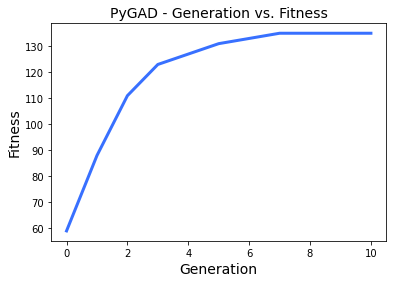

[0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


In [28]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
#print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Span of the best solution = " + str(GetSpan(solution, current_knot, GADefault, GAAlternate, True)))
print("Signature of the best solution = " + str(GetSignature(solution, current_knot, GADefault, GAAlternate)))
print(list(solution))
ga_instance.plot_fitness()
print (current_knot)

In [ ]:
#This is for running several algorithms in a row

fitness_list = []
for i in range(10):
    ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type,
                       mutation_type=mutation_type, mutation_percent_genes=mutation_percent_genes, gene_type = gene_type)
    # current_knot = [random.choice([1, 0]) for x in range(len(GADefault))]
    ga_instance.run()
    fitness_list.append(ga_instance.best_solution())
    #print(i)
    ga_instance.plot_fitness()

In [ ]:
#This allows for running several algorithms on the same knot while changing the metaparameters to test for improvements there

fitness_list1 = []
fitness_list2 = []
fitness_list3 = []
current_knot = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

for i in range(32):
    ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop, num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type,
                       mutation_type=mutation_type, mutation_percent_genes=mutation_percent_genes, gene_type = gene_type)
    ga_instance.run()
    fitness_list1.append(ga_instance.best_solution())
    print(i)
for i in range(4):
    ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_function,
                       initial_population = [ fitness_list1[j][0] for j in range( 8*i,8*(i+1) )  ], num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type,
                       mutation_type=mutation_type, mutation_percent_genes=mutation_percent_genes, gene_type = gene_type)
    ga_instance.run()
    fitness_list2.append(ga_instance.best_solution())
    print(i)
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, fitness_func=fitness_function,
                       initial_population = [ fitness_list2[j][0] for j in range(len(fitness_list2)) ], num_genes=num_genes, init_range_low=init_range_low, init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type, keep_parents=keep_parents, crossover_type=crossover_type,
                       mutation_type=mutation_type, mutation_percent_genes=mutation_percent_genes, gene_type = gene_type)
ga_instance.run()
fitness_list3.append(ga_instance.best_solution())


print(list(ga_instance.best_solution()[0]))
ga_instance.plot_fitness()
    